### Example training

Random tests for training networks

In [1]:
%%prun
import time
import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from recipes import train_segmentation_template_pytorch as train_pytorch
from recipes import train_segmentation_template_lightning as train_lightning
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('../data/vessel_mini/images'),
    'label_dir': Path('../data/vessel_mini/labels'),
    'crop_size': (256, 256),          
    'train_val_split': 0.1,
    'use_transforms': False,
    # Model
    'model_layers': (1, 1, 1), 
    'model_channels': (16,32,64), 
    'model_type': 'unet',
    # Training
    'epochs': 10,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, #132,
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.3414, 0.6586),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': '../logs_pt',
    'experiment':'unet_l_3_c_16_32_64',
    'save_every':1,                
    'save_best':True,
    # Other
    'resume': False,
}

t0 = time.time()
#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train_pytorch.run(params)
#Train using Pytorch Lightning
trainer, ds_train, ds_valid, lit_model = train_lightning.run(params)
print(time.time()-t0)

Global seed set to 12
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
e:\Miniconda3\envs\pytorch\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory .\../logs_pt\unet_l_3_c_16_32_64\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | ResUNet          | 199 K 
-----------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.800     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


37.306008100509644
 

         9102387 function calls (8904878 primitive calls) in 45.373 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      117   19.472    0.166   19.472    0.166 {built-in method _winapi.WaitForMultipleObjects}
     3408    3.962    0.001    3.962    0.001 {built-in method torch.conv2d}
    25012    1.886    0.000    1.886    0.000 {built-in method nt.stat}
     2092    1.478    0.001    1.478    0.001 {method 'to' of 'torch._C._TensorBase' objects}
       29    1.363    0.047    1.363    0.047 {built-in method _winapi.WaitForSingleObject}
        2    1.137    0.568    1.137    0.568 {method 'get_state' of 'torch._C.Generator' objects}
      120    1.083    0.009    1.083    0.009 {method 'run_backward' of 'torch._C._EngineBase' objects}
     4278    0.947    0.000    0.947    0.000 {built-in method io.open_code}
       22    0.940    0.043    0.946    0.043 perf_funcs.py:8(segmentation_accuracy)
    17501    0.561    0.00

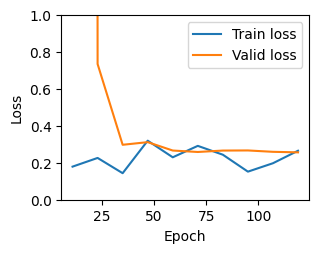

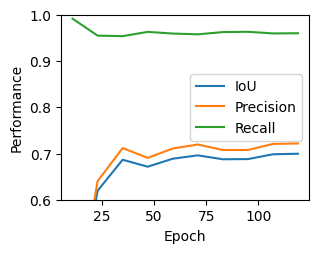

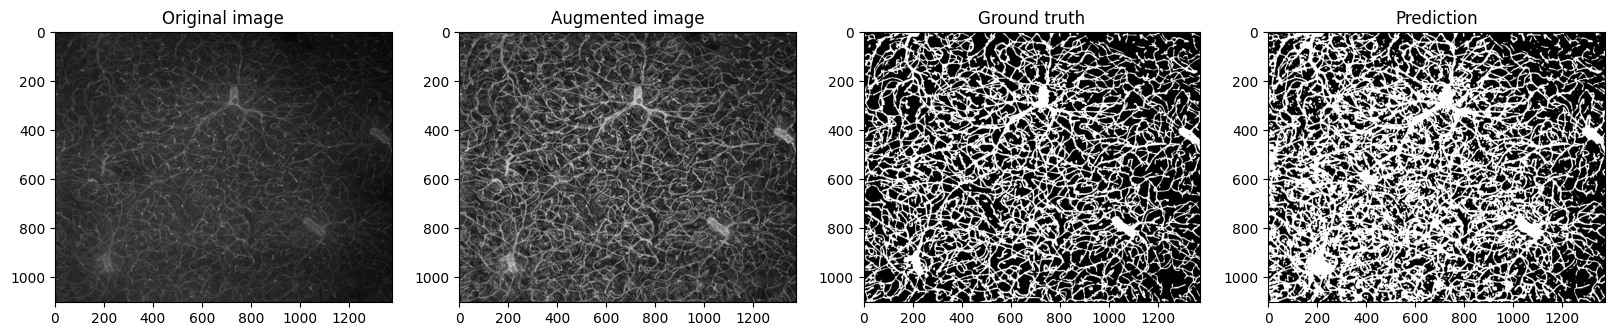

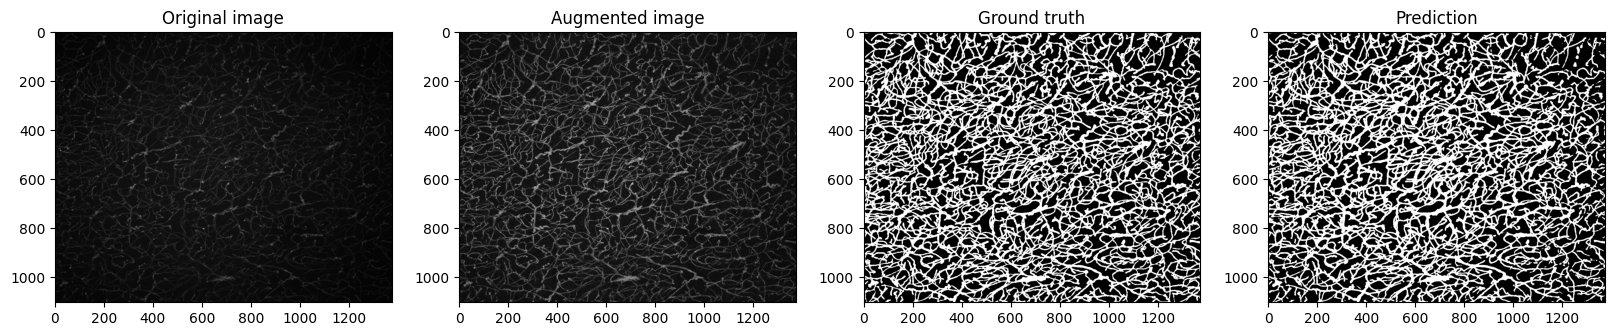

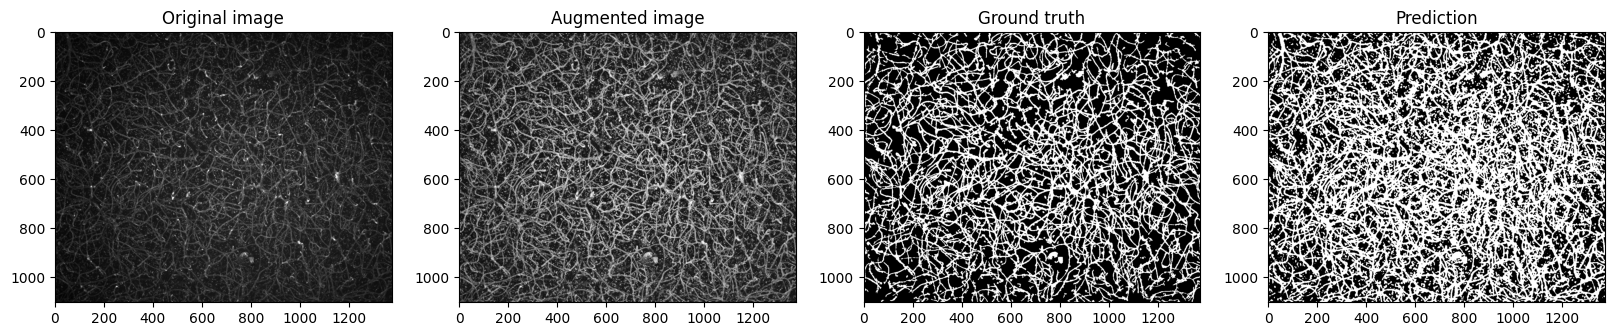

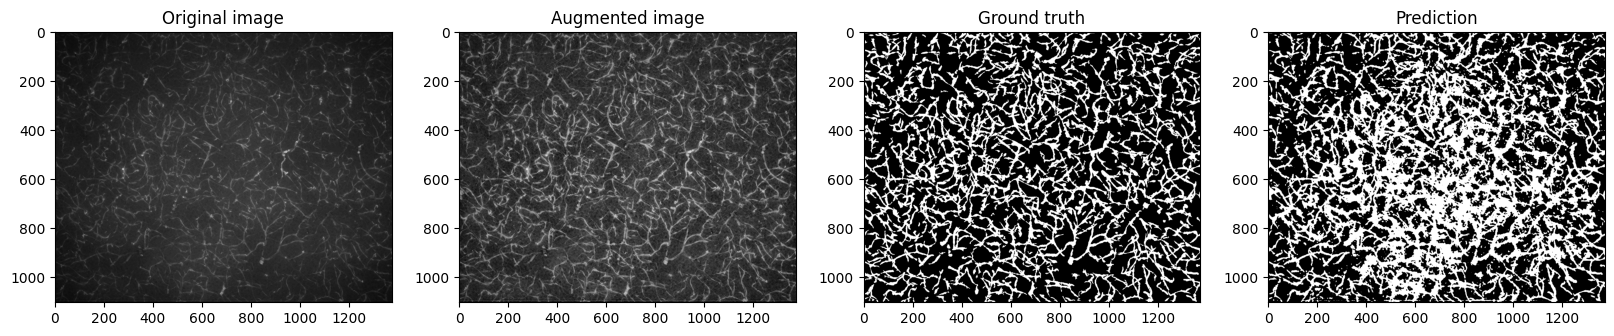

In [2]:
# Plot results
import matplotlib.pyplot as plt
def plot_metrics(logger, type='lt'):
    '''`lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = trainer.loggers[1].metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    else:
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

logger = trainer.loggers[1]
plot_metrics(logger)
plot_examples(ds_valid, model)

In [ ]:
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        if idx%10==0:
            print(idx)
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min(), output.max()))
stats

In [41]:
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
stats

In [4]:
insp = torchtrainer.inspector.Inspector(model)
#params = insp.get_params()
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=True):
        output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

In [ ]:
import torchtrainer
import torch

model = torchtrainer.models.resunet.ResUNet((1,1,1,1,1), (16,32,64,128,256))
torchtrainer.profiling.benchmark_model(model, (8, 1, 1104, 1376), no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
#torchtrainer.profiling.benchmark_model(model, (8, 1, 256, 256), no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
#model

### Tests

In [4]:
def gather_data(data, is_act=False):
    """Change data returned by the Inspector class from layer:stat to stat:layer."""

    data_l = []
    names = []
    for name, value in data.items():
        if is_act:
            data_l.append(value)
            names.append(name)           
        else:
            for param_name, param_value in value.items():
                data_l.append(param_value)
                names.append(name+'.'+param_name)

    mean, std, min, max = zip(*data_l)
    data_dict = {
        'mean':mean,
        'std':std,
        'min':min,
        'max':max,
        'names':names
    }

    return data_dict

def summarize_data(inspector):
    """Print the smallest and largest mean and standard deviation of each layer in the network. """

    params = inspector.get_params()
    grads = inspector.get_grads()
    acts = inspector.get_activations()
    param_dict = gather_data(params, is_act=False)
    grads_dict = gather_data(grads, is_act=False)
    acts_dict = gather_data(acts, is_act=True)
    data_dict = {'Param data':param_dict, 'Grad data':grads_dict, 'Activation data':acts_dict}
    print('Summary of data:')
    for data_type, data in data_dict.items():
        min_mean, max_mean = min(data['mean']), max(data['mean'])
        min_std, max_std = min(data['std']), max(data['std'])
        print(f'{data_type}: Smallest mean: {min_mean}, Largest mean: {max_mean}, Smallest std: {min_std}, Largest std: {max_std}')
        

In [ ]:
def plot_data(data, is_act=False):

    data_l = []
    names = []
    for name, value in data.items():
        if is_act:
            data_l.append(value)
            names.append(name)           
        else:
            for param_name, param_value in value.items():
                data_l.append(param_value)
                names.append(name+'.'+param_name)

    mean, std, min, max = zip(*data_l)

    plt.figure(figsize=(10, 5))
    plt.plot(names, mean, label='mean')
    plt.plot(names, std, label='std')
    plt.plot(names, min, label='min')
    plt.plot(names, max, label='max')
    plt.xticks(rotation=90)
    plt.legend()

insp = inspector.Inspector(model, agg_func=inspector.agg_func_stats)
insp.start_tracking_activations()
params = insp.get_params()
grads = insp.get_grads()
acts = insp.get_activations()
plot_data(acts, is_act=True)


In [ ]:
def create_histograms(data, is_act=False):

    min_val = torch.inf
    max_val = -torch.inf
    for name, value in data.items():
        if not is_act:
            value = value['weight']
        min = value.min()
        max = value.max()
        if min<min_val:
            min_val = min
        if max>max_val:
            max_val = max

    bins = torch.linspace(min_val, max_val, 100)
    hists = {}
    for name, value in data.items():
        if not is_act:
            value = value['weight']
        hist, _ = torch.histogram(value, bins)
        hists[name] = hist
        
    return hists, bins

def plot_histograms(hists, bins, figsize=(8, 20)):

    num_subplots = len(hists)
    plt.figure(figsize=figsize)
    for idx, (name, hist) in enumerate(hists.items()):
        plt.subplot(num_subplots, 1, idx+1)
        plt.plot(bins[:-1], hist)
        plt.title(name)
    plt.tight_layout()

params = insp.get_params()
grads = insp.get_grads()
acts = insp.get_activations()

hists, bins = create_histograms(params, True)
plot_histograms(hists, bins)